In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
import sys
import pathlib
import pickle
import warnings

sys.path.append('..')

In [4]:
import pandas as pd
from loguru import logger
import seaborn as sns

In [5]:
from pals.pimp_tools import get_pimp_API_token_from_env, PIMP_HOST, download_from_pimp
from pals.noise import construct_intensity_df, add_random_peaks, plot_intensity_matrix, convert_to_data_source
from pals.feature_extraction import DataSource
from pals.pathway_analysis import PALS
from pals.common import *

2019-12-20 02:22:43.351 | WARNING  | pals.reactome:get_neo4j_driver:14 - Using a default neo4j server: bolt://localhost:7687
2019-12-20 02:22:43.351 | WARNING  | pals.reactome:get_neo4j_driver:19 - Using a default neo4j username or password: neo4j
2019-12-20 02:22:44.407 | INFO     | pals.reactome:get_neo4j_driver:24 - Created graph database driver for bolt://localhost:7687 (neo4j)


## Synthetic data test

Try generating some synthetic data without noise

In [6]:
control_fnames = ['Control_1.mzXML', 'Control_2.mzXML', 'Control_3.mzXML', 'Control_4.mzXML']
case_fnames = ['Case_1.mzXML', 'Case_2.mzXML', 'Case_3.mzXML', 'Case_4.mzXML']
sample_fnames = control_fnames + case_fnames

pathway_names ={'two':2, 'four':4, 'six':6, 'ten':10, 'twenty':20, 'forty':40, 'eighty':80}

(162, 8)


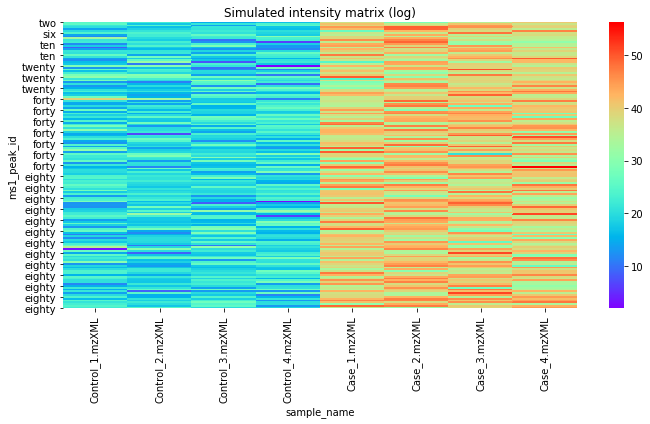

In [7]:
int_df = construct_intensity_df(sample_fnames, pathway_names, random=False)
print(int_df.shape)
plot_intensity_matrix(int_df)

Convert simulated data above to a PALS DataSource object and run pathway analysis

In [8]:
min_replace = 5000
plage_weight = 5
hg_weight = 1
prob_missing_peaks = 0.2

In [9]:
ds = convert_to_data_source(int_df, pathway_names, case_fnames, control_fnames, prob_missing_peaks)
pals = PALS(ds, min_replace=min_replace, plage_weight=plage_weight, hg_weight=hg_weight)

2019-12-20 02:22:45.001 | DEBUG    | pals.noise:convert_to_data_source:90 - Dataset annotations = 162
2019-12-20 02:22:45.003 | DEBUG    | pals.noise:convert_to_data_source:94 - Sampled annotations = 130 with prob_missing_peaks=0.20
2019-12-20 02:22:45.003 | DEBUG    | pals.feature_extraction:__init__:43 - Using user-provided database
2019-12-20 02:22:45.004 | DEBUG    | pals.feature_extraction:__init__:51 - Mapping pathway to unique ids
2019-12-20 02:22:45.004 | DEBUG    | pals.feature_extraction:__init__:65 - Creating dataset to pathway mapping
2019-12-20 02:22:45.014 | DEBUG    | pals.feature_extraction:__init__:93 - Computing unique id counts


In [10]:
pals_df = pals.get_pathway_df()
pals_df

2019-12-20 02:22:45.086 | DEBUG    | pals.pathway_analysis:_change_zero_peak_ints:406 - Setting the zero intensity values in the dataframe
2019-12-20 02:22:45.101 | DEBUG    | pals.pathway_analysis:_standardize_intensity_df:387 - Scaling the data across the sample: zero mean and unit variance
2019-12-20 02:22:45.105 | DEBUG    | pals.pathway_analysis:get_plage_activity_df:214 - Mean values of the rows in the DF is [-0.  0. -0. -0. -0. -0.  0. -0.  0.  0. -0. -0. -0. -0. -0. -0.  0. -0.
  0.  0. -0. -0.  0. -0. -0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.
  0. -0.  0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0.  0. -0.
  0. -0. -0. -0.  0.  0. -0. -0.  0.  0. -0. -0. -0.  0. -0.  0. -0.  0.
 -0. -0. -0.  0.  0.  0.  0. -0. -0.  0. -0.  0. -0. -0. -0.  0.  0. -0.
 -0.  0. -0. -0.  0. -0.  0.  0.  0.  0.  0.  0. -0.  0.  0. -0. -0. -0.
 -0.  0.  0. -0.  0. -0. -0.  0.  0. -0.  0. -0. -0. -0. -0.  0. -0. -0.
  0.  0. -0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0. -0.  0.  0. -0. -0

,pw_name,case/control p-value,unq_pw_F,tot_ds_F,F_coverage,sf,exp_F,Ex_Cov,case/control comb_p
ten,ten,1.614675e-04,10,8,80.00,0.687466,8.02,80.20,3.012371e-04
six,six,4.770123e-03,6,5,83.33,0.661549,4.81,80.17,6.946735e-03
twenty,twenty,2.728317e-03,20,15,75.00,0.825799,16.05,80.25,5.528304e-03
forty,forty,6.620737e-08,40,30,75.00,0.881426,32.10,80.25,3.882404e-07
two,two,5.390499e-02,2,2,100.00,0.642972,1.60,80.00,6.615861e-02
eighty,eighty,3.290549e-07,80,66,82.50,0.303967,64.20,80.25,3.222735e-07
four,four,4.006905e-03,4,4,100.00,0.410855,3.21,80.25,4.094319e-03


In [11]:
ora_df = pals.get_ora_df(correct_multiple_tests=False)
ora_df

2019-12-20 02:22:46.262 | DEBUG    | pals.pathway_analysis:get_ora_df:50 - Calculating ORA
2019-12-20 02:22:46.263 | DEBUG    | pals.pathway_analysis:_change_zero_peak_ints:406 - Setting the zero intensity values in the dataframe
2019-12-20 02:22:46.280 | DEBUG    | pals.pathway_analysis:get_ora_df:92 - pw=ten comp=case/control M=162 n=128 N=10 k=8 sf=0.648968
2019-12-20 02:22:46.283 | DEBUG    | pals.pathway_analysis:get_ora_df:92 - pw=six comp=case/control M=162 n=128 N=6 k=5 sf=0.630738
2019-12-20 02:22:46.286 | DEBUG    | pals.pathway_analysis:get_ora_df:92 - pw=twenty comp=case/control M=162 n=128 N=20 k=15 sf=0.782840
2019-12-20 02:22:46.289 | DEBUG    | pals.pathway_analysis:get_ora_df:92 - pw=forty comp=case/control M=162 n=128 N=40 k=28 sf=0.963898
2019-12-20 02:22:46.293 | DEBUG    | pals.pathway_analysis:get_ora_df:92 - pw=two comp=case/control M=162 n=128 N=2 k=2 sf=0.623265
2019-12-20 02:22:46.297 | DEBUG    | pals.pathway_analysis:get_ora_df:92 - pw=eighty comp=case/contr

,pw_name,case/control p-value,case/control comb_p,unq_pw_F,tot_ds_F,F_coverage
mapids,,,,,,
ten,ten,0.648968,0.648968,10,8,80.00
six,six,0.630738,0.630738,6,5,83.33
twenty,twenty,0.782840,0.782840,20,15,75.00
forty,forty,0.963898,0.963898,40,30,75.00
two,two,0.623265,0.623265,2,2,100.00
eighty,eighty,0.188545,0.188545,80,66,82.50
four,four,0.385866,0.385866,4,4,100.00


Now take the synthetic data matrix above, add some noisy peaks (100%) and run pathway analysis methods again.

(324, 8)


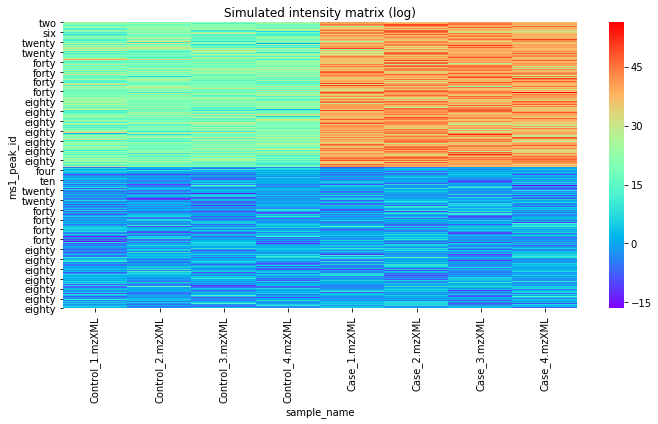

In [12]:
percent = 100
noise_mean = 0
noise_std = 5
int_df = add_random_peaks(sample_fnames, pathway_names, int_df, percent, noise_mean, noise_std)
print(int_df.shape)
plot_intensity_matrix(int_df)

In [13]:
ds = convert_to_data_source(int_df, pathway_names, case_fnames, control_fnames, prob_missing_peaks)
pals = PALS(ds, min_replace=min_replace, plage_weight=plage_weight, hg_weight=hg_weight)

2019-12-20 02:22:46.747 | DEBUG    | pals.noise:convert_to_data_source:90 - Dataset annotations = 324
2019-12-20 02:22:46.748 | DEBUG    | pals.noise:convert_to_data_source:94 - Sampled annotations = 259 with prob_missing_peaks=0.20
2019-12-20 02:22:46.748 | DEBUG    | pals.feature_extraction:__init__:43 - Using user-provided database
2019-12-20 02:22:46.749 | DEBUG    | pals.feature_extraction:__init__:51 - Mapping pathway to unique ids
2019-12-20 02:22:46.750 | DEBUG    | pals.feature_extraction:__init__:65 - Creating dataset to pathway mapping
2019-12-20 02:22:46.769 | DEBUG    | pals.feature_extraction:__init__:93 - Computing unique id counts


In [14]:
pals_df = pals.get_pathway_df()
pals_df

2019-12-20 02:22:46.845 | DEBUG    | pals.pathway_analysis:_change_zero_peak_ints:406 - Setting the zero intensity values in the dataframe
2019-12-20 02:22:46.857 | DEBUG    | pals.pathway_analysis:_standardize_intensity_df:387 - Scaling the data across the sample: zero mean and unit variance
2019-12-20 02:22:46.861 | DEBUG    | pals.pathway_analysis:get_plage_activity_df:214 - Mean values of the rows in the DF is [-0.  0. -0. -0. -0. -0.  0. -0.  0.  0. -0. -0. -0. -0. -0. -0.  0. -0.
  0.  0. -0. -0.  0. -0. -0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.
  0. -0.  0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0.  0. -0.
  0. -0. -0. -0.  0.  0. -0. -0.  0.  0. -0. -0. -0.  0. -0.  0. -0.  0.
 -0. -0. -0.  0.  0.  0.  0. -0. -0.  0. -0.  0. -0. -0. -0.  0.  0. -0.
 -0.  0. -0. -0.  0. -0.  0.  0.  0.  0.  0.  0. -0.  0.  0. -0. -0. -0.
 -0.  0.  0. -0.  0. -0. -0.  0.  0. -0.  0. -0. -0. -0. -0.  0. -0. -0.
  0.  0. -0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0. -0.  0.  0. -0. -0

,pw_name,case/control p-value,unq_pw_F,tot_ds_F,F_coverage,sf,exp_F,Ex_Cov,case/control comb_p
ten,ten,0.020947,20,17,85.00,0.403107,15.99,79.95,0.020518
six,six,0.073271,12,8,66.67,0.930385,9.59,79.92,0.128466
twenty,twenty,0.025390,40,25,62.50,0.998471,31.98,79.95,0.091012
forty,forty,0.020084,80,63,78.75,0.684055,63.95,79.94,0.027542
two,two,0.102358,4,3,75.00,0.819207,3.20,80.00,0.143511
eighty,eighty,0.010266,160,136,85.00,0.017179,127.90,79.94,0.003611
four,four,0.036766,8,7,87.50,0.499653,6.40,80.00,0.039635


In [15]:
ora_df = pals.get_ora_df(correct_multiple_tests=False)
ora_df

2019-12-20 02:22:48.031 | DEBUG    | pals.pathway_analysis:get_ora_df:50 - Calculating ORA
2019-12-20 02:22:48.032 | DEBUG    | pals.pathway_analysis:_change_zero_peak_ints:406 - Setting the zero intensity values in the dataframe
2019-12-20 02:22:48.051 | DEBUG    | pals.pathway_analysis:get_ora_df:92 - pw=ten comp=case/control M=324 n=135 N=20 k=9 sf=0.464415
2019-12-20 02:22:48.054 | DEBUG    | pals.pathway_analysis:get_ora_df:92 - pw=six comp=case/control M=324 n=135 N=12 k=4 sf=0.813183
2019-12-20 02:22:48.057 | DEBUG    | pals.pathway_analysis:get_ora_df:92 - pw=twenty comp=case/control M=324 n=135 N=40 k=13 sf=0.924725
2019-12-20 02:22:48.060 | DEBUG    | pals.pathway_analysis:get_ora_df:92 - pw=forty comp=case/control M=324 n=135 N=80 k=35 sf=0.379021
2019-12-20 02:22:48.064 | DEBUG    | pals.pathway_analysis:get_ora_df:92 - pw=two comp=case/control M=324 n=135 N=4 k=1 sf=0.885747
2019-12-20 02:22:48.068 | DEBUG    | pals.pathway_analysis:get_ora_df:92 - pw=eighty comp=case/cont

,pw_name,case/control p-value,case/control comb_p,unq_pw_F,tot_ds_F,F_coverage
mapids,,,,,,
ten,ten,0.464415,0.464415,20,17,85.00
six,six,0.813183,0.813183,12,8,66.67
twenty,twenty,0.924725,0.924725,40,25,62.50
forty,forty,0.379021,0.379021,80,63,78.75
two,two,0.885747,0.885747,4,3,75.00
eighty,eighty,0.425498,0.425498,160,136,85.00
four,four,0.197696,0.197696,8,7,87.50


### Experiments

The following are all the methods we need to run our experiments

In [16]:
def run_experiment(reqd_scenarios, sample_fnames, pathway_names, num_iterations):
    pals_dfs = []
    ora_dfs = []
    for i in range(len(reqd_scenarios)):
        scenario = reqd_scenarios[i]
        logger.info(scenario)
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', r'divide by zero')
            results = calc_av_p_scores(sample_fnames, pathway_names, num_iterations, 
                                  percent=scenario['percent'], random=scenario['random'], noise_std=scenario['noise_std'],
                                  prob_missing_peaks=scenario['prob_missing_peaks'])
        df = construct_single_box_df(results, scenario['percent'], scenario['prob_missing_peaks'], scenario['noise_std'], 'pals')        
        pals_dfs.append(df)
        df = construct_single_box_df(results, scenario['percent'], scenario['prob_missing_peaks'], scenario['noise_std'], 'ora')        
        ora_dfs.append(df)   

    pals_df = pd.concat(pals_dfs, axis=0)
    ora_df = pd.concat(ora_dfs, axis=0)
    return pals_df, ora_df

In [17]:
def calc_av_p_scores(sample_fnames, pathway_names, num_iterations, percent=None, random=False, noise_mean=0, noise_std=5, prob_missing_peaks=0.2):
    results = {
        'pals': [],
        'ora': []
    }
    
    set_log_level_info()
    for it in range(num_iterations):
        if it % 10 == 0:
            logger.info('Iteration %d' % it)
        # constructs the peak intensity dataframe, adding random peaks if necessary
        int_df = construct_intensity_df(sample_fnames, pathway_names, random=random)        
        if percent is not None: # have random peaks
            int_df = add_random_peaks(sample_fnames, pathway_names, int_df, percent, noise_mean, noise_std)
            
        ds = convert_to_data_source(int_df, pathway_names, case_fnames, control_fnames, prob_missing_peaks)        
        pals = PALS(ds, min_replace=5000, plage_weight=5, hg_weight=1)
        pathway_df = pals.get_pathway_df()
        ora_df = pals.get_ora_df(correct_multiple_tests=False)
        
        results['pals'].append(pathway_df)
        results['ora'].append(ora_df)

    set_log_level_debug()
    return results

In [18]:
def construct_single_box_df(results, random_peaks, prob_missing, noise_std, method):
    df = pd.concat(results[method], axis=0)
    columns = ['pathway', 'percent', 'prob_missing', 'noise_std', 'p_value', 'comb_p_value', 'method']
    box_plot_df = pd.DataFrame(columns=columns)
    box_plot_df['pathway'] = list(df.index)
    box_plot_df['percent'] = float(random_peaks)
    box_plot_df['prob_missing'] = float(prob_missing)    
    box_plot_df['noise_std'] = float(noise_std)        
    box_plot_df['p_value'] = df['case/control p-value'].values
    box_plot_df['comb_p_value'] = df['case/control comb_p'].values
    box_plot_df['method'] = method
    return box_plot_df

In [19]:
NUM_ITERATIONS = 500

### Experiment 1: adding noise

In this experiment, we add some % of noise to the data, and compares how the different methods perform.

In [20]:
prob_missing_peaks = 0.2
random = False # whether to sample intensity data randomly or using pre-set values
reqd_scenarios = [
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 0, 'prob_missing_peaks': prob_missing_peaks },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 50, 'prob_missing_peaks': prob_missing_peaks },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 100, 'prob_missing_peaks': prob_missing_peaks },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 500, 'prob_missing_peaks': prob_missing_peaks },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 1000, 'prob_missing_peaks': prob_missing_peaks },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 5000, 'prob_missing_peaks': prob_missing_peaks },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 10000, 'prob_missing_peaks': prob_missing_peaks },    
]
pals_df, ora_df = run_experiment(reqd_scenarios, sample_fnames, pathway_names, NUM_ITERATIONS)

2019-12-20 02:22:48.445 | INFO     | __main__:run_experiment:6 - {'num_iterations': 500, 'random': False, 'noise_std': 5, 'percent': 0, 'prob_missing_peaks': 0.2}
2019-12-20 02:22:48.446 | INFO     | __main__:calc_av_p_scores:10 - Iteration 0
2019-12-20 02:22:59.302 | INFO     | __main__:calc_av_p_scores:10 - Iteration 10
2019-12-20 02:23:10.285 | INFO     | __main__:calc_av_p_scores:10 - Iteration 20
2019-12-20 02:23:21.967 | INFO     | __main__:calc_av_p_scores:10 - Iteration 30
2019-12-20 02:23:32.791 | INFO     | __main__:calc_av_p_scores:10 - Iteration 40
2019-12-20 02:23:43.878 | INFO     | __main__:calc_av_p_scores:10 - Iteration 50
2019-12-20 02:23:54.942 | INFO     | __main__:calc_av_p_scores:10 - Iteration 60
2019-12-20 02:24:06.747 | INFO     | __main__:calc_av_p_scores:10 - Iteration 70
2019-12-20 02:24:17.801 | INFO     | __main__:calc_av_p_scores:10 - Iteration 80
2019-12-20 02:24:28.594 | INFO     | __main__:calc_av_p_scores:10 - Iteration 90
2019-12-20 02:24:39.695 | IN

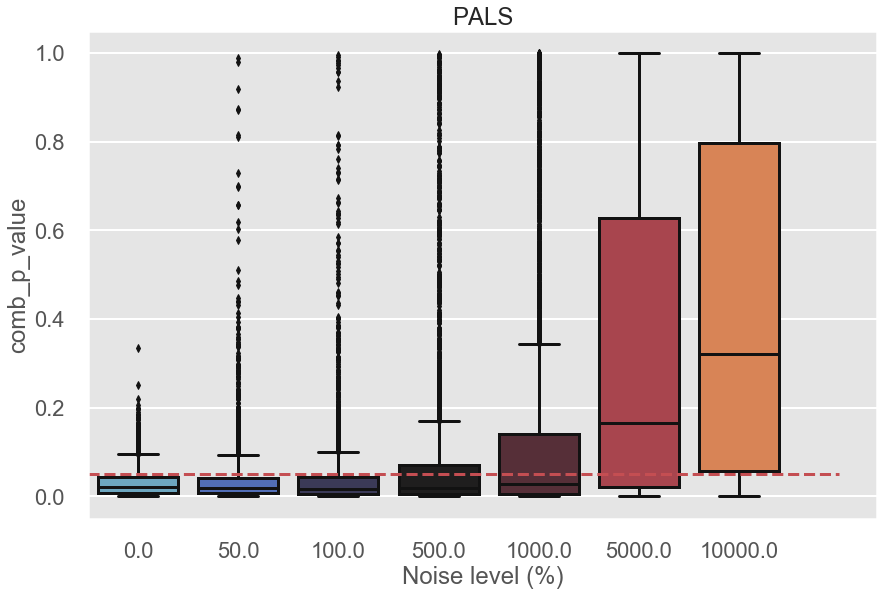

In [21]:
style.use('seaborn-poster') #sets the size of the charts
sns.set(style="whitegrid")
style.use('ggplot')
sns.set_context('poster')  #Everything is larger

ax = sns.boxplot(x="percent", y="comb_p_value", data=pals_df, palette=("icefire"))
# ax = sns.swarmplot(x="percent", y="p_value", hue="Pathway", data=box_plot_df, size=10, palette=("YlGnBu"))
ax.set(xlabel='Noise level (%)', ylabel='comb_p_value')
plt.plot([-0.5, 7], [0.05, 0.05], 'r--')
plt.title('PALS')
plt.tight_layout()
plt.savefig('adding_noise_pals.eps', dpi=300)

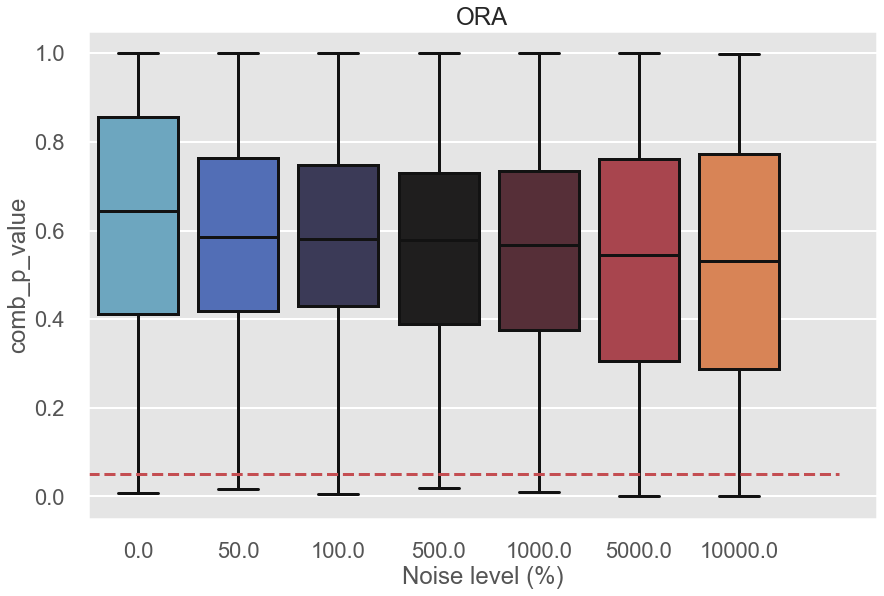

In [22]:
style.use('seaborn-poster') #sets the size of the charts
sns.set(style="whitegrid")
style.use('ggplot')
sns.set_context('poster')  #Everything is larger

ax = sns.boxplot(x="percent", y="comb_p_value", data=ora_df, palette=("icefire"))
# ax = sns.swarmplot(x="percent", y="p_value", hue="Pathway", data=box_plot_df, size=10, palette=("YlGnBu"))
ax.set(xlabel='Noise level (%)', ylabel='comb_p_value')
plt.plot([-0.5, 7], [0.05, 0.05], 'r--')
plt.title('ORA')
plt.tight_layout()
plt.savefig('adding_noise_ora.eps', dpi=300)

### Experiment 2: introducing missing peaks

In this experiment, we add a fixed (100%) noisy peaks, then increase the number of missing peaks in the data.

In [23]:
percent = 100
random = False # whether to sample intensity data randomly or using pre-set values
reqd_scenarios = [
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': percent, 'prob_missing_peaks': 0.2 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': percent, 'prob_missing_peaks': 0.4 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': percent, 'prob_missing_peaks': 0.6 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': percent, 'prob_missing_peaks': 0.8 },
]
pals_df, ora_df = run_experiment(reqd_scenarios, sample_fnames, pathway_names, NUM_ITERATIONS)

2019-12-20 04:05:37.579 | INFO     | __main__:run_experiment:6 - {'num_iterations': 500, 'random': False, 'noise_std': 5, 'percent': 100, 'prob_missing_peaks': 0.2}
2019-12-20 04:05:37.580 | INFO     | __main__:calc_av_p_scores:10 - Iteration 0
2019-12-20 04:05:48.233 | INFO     | __main__:calc_av_p_scores:10 - Iteration 10
2019-12-20 04:05:58.894 | INFO     | __main__:calc_av_p_scores:10 - Iteration 20
2019-12-20 04:06:09.663 | INFO     | __main__:calc_av_p_scores:10 - Iteration 30
2019-12-20 04:06:20.431 | INFO     | __main__:calc_av_p_scores:10 - Iteration 40
2019-12-20 04:06:31.113 | INFO     | __main__:calc_av_p_scores:10 - Iteration 50
2019-12-20 04:06:41.834 | INFO     | __main__:calc_av_p_scores:10 - Iteration 60
2019-12-20 04:06:52.688 | INFO     | __main__:calc_av_p_scores:10 - Iteration 70
2019-12-20 04:07:03.513 | INFO     | __main__:calc_av_p_scores:10 - Iteration 80
2019-12-20 04:07:14.240 | INFO     | __main__:calc_av_p_scores:10 - Iteration 90
2019-12-20 04:07:25.167 | 

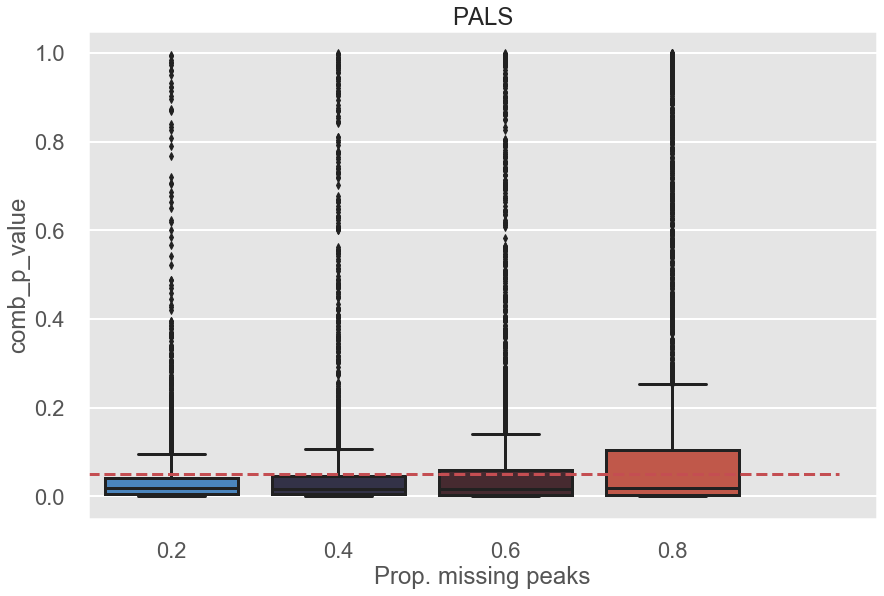

In [24]:
style.use('seaborn-poster') #sets the size of the charts
sns.set(style="whitegrid")
style.use('ggplot')
sns.set_context('poster')  #Everything is larger

ax = sns.boxplot(x="prob_missing", y="comb_p_value", data=pals_df, palette=("icefire"))
# ax = sns.swarmplot(x="prob_missing", y="comb_p_value", hue="pathway", data=pals_df, size=10, palette=("YlGnBu"))
ax.set(xlabel='Prop. missing peaks', ylabel='comb_p_value')
plt.plot([-0.5, 4], [0.05, 0.05], 'r--')
plt.title("PALS")
plt.tight_layout()
plt.savefig('missing_peaks_pals.eps', dpi=300)

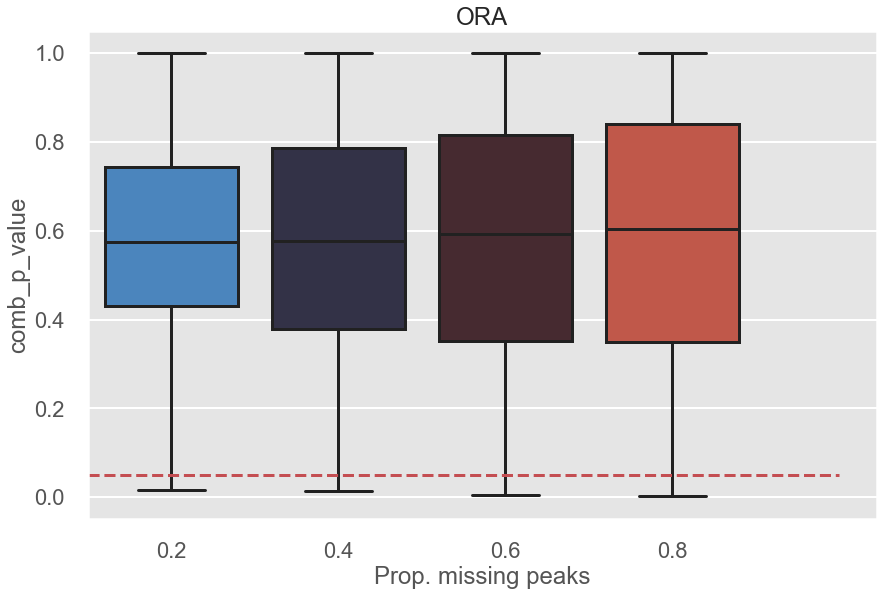

In [25]:
style.use('seaborn-poster') #sets the size of the charts
sns.set(style="whitegrid")
style.use('ggplot')
sns.set_context('poster')  #Everything is larger

ax = sns.boxplot(x="prob_missing", y="comb_p_value", data=ora_df, palette=("icefire"))
# ax = sns.swarmplot(x="prob_missing", y="comb_p_value", hue="pathway", data=ora_df, size=10, palette=("YlGnBu"))
ax.set(xlabel='Prop. missing peaks', ylabel='comb_p_value')
plt.plot([-0.5, 4], [0.05, 0.05], 'r--')
plt.title("ORA")
plt.tight_layout()
plt.savefig('missing_peaks_ora.eps', dpi=300)

### Experiment 3: pathway ranking vs noise level

Here we perform an experiment to see how the different methods rank pathways based on their size and in the presence of increasing noise.

#### Noise std deviation = 1

In [26]:
random = False # whether to sample intensity data randomly or using pre-set values
noise_std = 1
reqd_scenarios = [
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 0, 'prob_missing_peaks': 0.2 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 50, 'prob_missing_peaks': 0.2 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 100, 'prob_missing_peaks': 0.2 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 500, 'prob_missing_peaks': 0.2 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 1000, 'prob_missing_peaks': 0.2 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 5000, 'prob_missing_peaks': 0.2 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 10000, 'prob_missing_peaks': 0.2 },
]
pals_df, ora_df = run_experiment(reqd_scenarios, sample_fnames, pathway_names, NUM_ITERATIONS)

2019-12-20 04:41:25.441 | INFO     | __main__:run_experiment:6 - {'num_iterations': 500, 'random': False, 'noise_std': 1, 'percent': 0, 'prob_missing_peaks': 0.2}
2019-12-20 04:41:25.442 | INFO     | __main__:calc_av_p_scores:10 - Iteration 0
2019-12-20 04:41:36.105 | INFO     | __main__:calc_av_p_scores:10 - Iteration 10
2019-12-20 04:41:46.485 | INFO     | __main__:calc_av_p_scores:10 - Iteration 20
2019-12-20 04:41:56.956 | INFO     | __main__:calc_av_p_scores:10 - Iteration 30
2019-12-20 04:42:07.581 | INFO     | __main__:calc_av_p_scores:10 - Iteration 40
2019-12-20 04:42:18.363 | INFO     | __main__:calc_av_p_scores:10 - Iteration 50
2019-12-20 04:42:28.977 | INFO     | __main__:calc_av_p_scores:10 - Iteration 60
2019-12-20 04:42:39.627 | INFO     | __main__:calc_av_p_scores:10 - Iteration 70
2019-12-20 04:42:50.147 | INFO     | __main__:calc_av_p_scores:10 - Iteration 80
2019-12-20 04:43:00.772 | INFO     | __main__:calc_av_p_scores:10 - Iteration 90
2019-12-20 04:43:11.500 | IN

In [27]:
pals_df['pathway'] = pd.Categorical(pals_df['pathway'], ['eighty', 'forty', 'twenty', 'ten', 'six', 'four', 'two'])
ora_df['pathway'] = pd.Categorical(ora_df['pathway'], ['eighty', 'forty', 'twenty', 'ten', 'six', 'four', 'two'])

pals_df = pals_df.sort_values('pathway')
ora_df = ora_df.sort_values('pathway')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


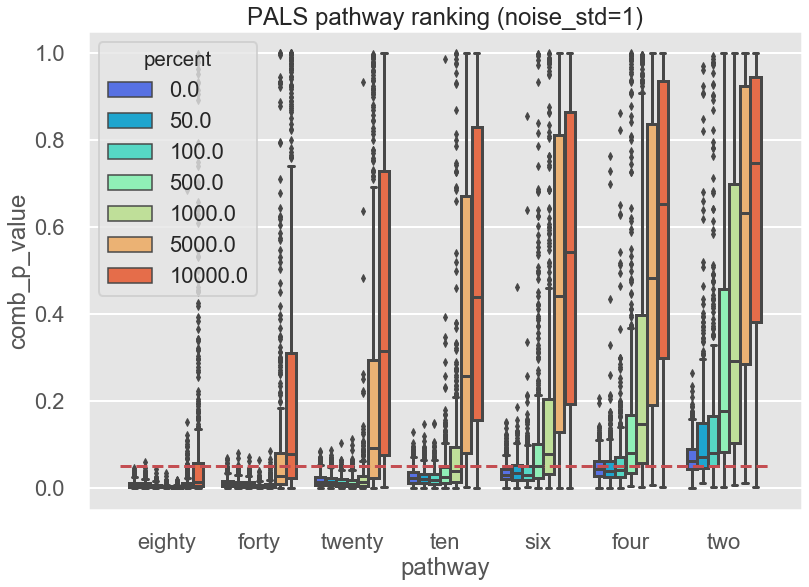

In [28]:
sns.boxplot(x='pathway', y='comb_p_value', hue='percent', data=pals_df, palette=("rainbow"))
plt.title('PALS pathway ranking (noise_std=%d)' % noise_std)
plt.plot([-0.5, 6.5], [0.05, 0.05], 'r--')
plt.savefig('pathway_ranking_pals_1.eps', dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


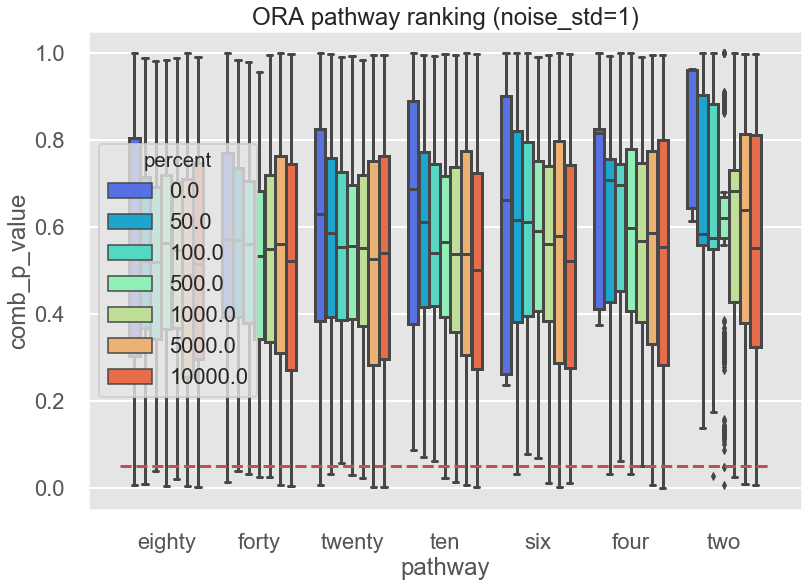

In [29]:
sns.boxplot(x='pathway', y='comb_p_value', hue='percent', data=ora_df, palette=("rainbow"))
plt.title('ORA pathway ranking (noise_std=%d)' % noise_std)
plt.plot([-0.5, 6.5], [0.05, 0.05], 'r--')
plt.savefig('pathway_ranking_ora_1.eps', dpi=300)

#### Noise std deviation = 5

In [30]:
random = False # whether to sample intensity data randomly or using pre-set values
noise_std = 5
reqd_scenarios = [
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 0, 'prob_missing_peaks': 0.2 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 50, 'prob_missing_peaks': 0.2 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 100, 'prob_missing_peaks': 0.2 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 500, 'prob_missing_peaks': 0.2 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 1000, 'prob_missing_peaks': 0.2 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 5000, 'prob_missing_peaks': 0.2 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': noise_std, 'percent': 10000, 'prob_missing_peaks': 0.2 },
]
pals_df, ora_df = run_experiment(reqd_scenarios, sample_fnames, pathway_names, NUM_ITERATIONS)

2019-12-20 06:24:19.090 | INFO     | __main__:run_experiment:6 - {'num_iterations': 500, 'random': False, 'noise_std': 5, 'percent': 0, 'prob_missing_peaks': 0.2}
2019-12-20 06:24:19.091 | INFO     | __main__:calc_av_p_scores:10 - Iteration 0
2019-12-20 06:24:29.707 | INFO     | __main__:calc_av_p_scores:10 - Iteration 10
2019-12-20 06:24:40.325 | INFO     | __main__:calc_av_p_scores:10 - Iteration 20
2019-12-20 06:24:51.043 | INFO     | __main__:calc_av_p_scores:10 - Iteration 30
2019-12-20 06:25:01.790 | INFO     | __main__:calc_av_p_scores:10 - Iteration 40
2019-12-20 06:25:12.273 | INFO     | __main__:calc_av_p_scores:10 - Iteration 50
2019-12-20 06:25:23.043 | INFO     | __main__:calc_av_p_scores:10 - Iteration 60
2019-12-20 06:25:33.694 | INFO     | __main__:calc_av_p_scores:10 - Iteration 70
2019-12-20 06:25:44.236 | INFO     | __main__:calc_av_p_scores:10 - Iteration 80
2019-12-20 06:25:54.986 | INFO     | __main__:calc_av_p_scores:10 - Iteration 90
2019-12-20 06:26:05.640 | IN

In [31]:
pals_df['pathway'] = pd.Categorical(pals_df['pathway'], ['eighty', 'forty', 'twenty', 'ten', 'six', 'four', 'two'])
ora_df['pathway'] = pd.Categorical(ora_df['pathway'], ['eighty', 'forty', 'twenty', 'ten', 'six', 'four', 'two'])

pals_df = pals_df.sort_values('pathway')
ora_df = ora_df.sort_values('pathway')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


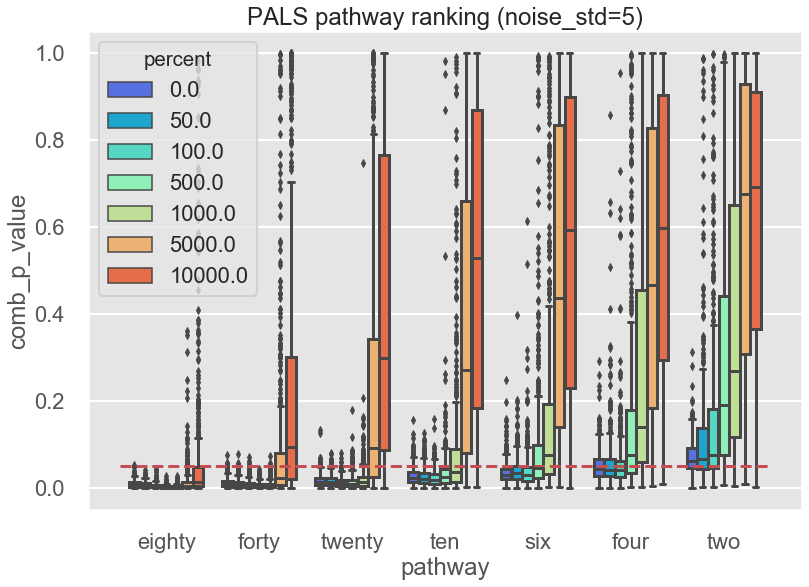

In [32]:
sns.boxplot(x='pathway', y='comb_p_value', hue='percent', data=pals_df, palette=("rainbow"))
plt.title('PALS pathway ranking (noise_std=%d)' % noise_std)
plt.plot([-0.5, 6.5], [0.05, 0.05], 'r--')
plt.savefig('pathway_ranking_pals_5.eps', dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


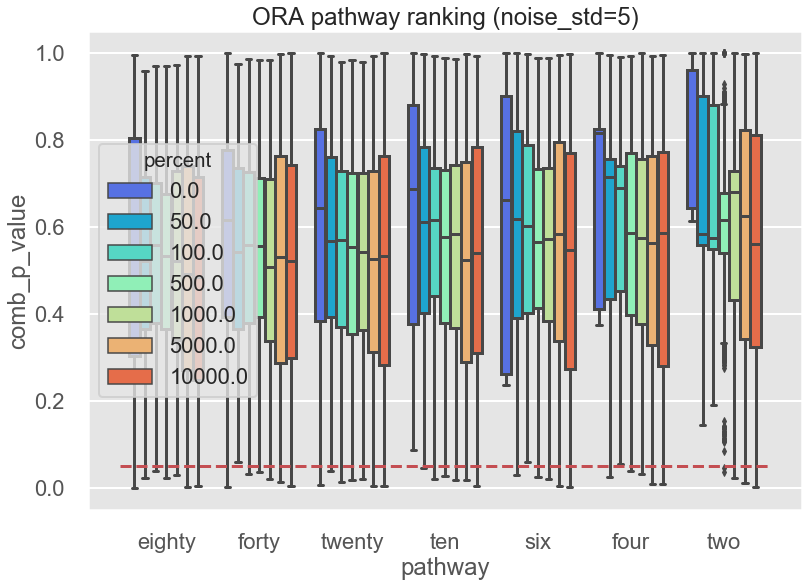

In [33]:
sns.boxplot(x='pathway', y='comb_p_value', hue='percent', data=ora_df, palette=("rainbow"))
plt.title('ORA pathway ranking (noise_std=%d)' % noise_std)
plt.plot([-0.5, 6.5], [0.05, 0.05], 'r--')
plt.savefig('pathway_ranking_ora_5.eps', dpi=300)

#### Nothing is changing, it's all random

In [34]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'divide by zero')
    results = calc_av_p_scores(sample_fnames, pathway_names, num_iterations=1, random=True)
    pals_df = construct_single_box_df(results, 100, 0.2, 1, 'pals')      
    ora_df = construct_single_box_df(results, 100, 0.2, 1, 'ora')   

2019-12-20 08:07:18.808 | INFO     | __main__:calc_av_p_scores:10 - Iteration 0


In [35]:
pals_df

,pathway,percent,prob_missing,noise_std,p_value,comb_p_value,method
0,ten,100.0,0.2,1.0,0.992704,0.997227,pals
1,six,100.0,0.2,1.0,0.974451,0.976951,pals
2,twenty,100.0,0.2,1.0,0.876962,0.937474,pals
3,forty,100.0,0.2,1.0,0.999180,0.999170,pals
4,two,100.0,0.2,1.0,0.035609,0.077637,pals
5,eighty,100.0,0.2,1.0,0.928677,0.847156,pals
6,four,100.0,0.2,1.0,0.139285,0.189634,pals


In [36]:
ora_df

,pathway,percent,prob_missing,noise_std,p_value,comb_p_value,method
0,ten,100.0,0.2,1.0,1.000000,1.000000,ora
1,six,100.0,0.2,1.0,1.000000,1.000000,ora
2,twenty,100.0,0.2,1.0,0.257426,0.257426,ora
3,forty,100.0,0.2,1.0,1.000000,1.000000,ora
4,two,100.0,0.2,1.0,0.096618,0.096618,ora
5,eighty,100.0,0.2,1.0,0.626365,0.626365,ora
6,four,100.0,0.2,1.0,0.184968,0.184968,ora
